In [1]:
# Introduction


In [2]:
""" 
This example show how to do structured data classification using the two modeling techniques:

Wide & Deep models
Deep & Cross models 
"""

' \nThis example show how to do structured data classification using the two modeling techniques:\n\nWide & Deep models\nDeep & Cross models \n'

In [3]:
# The dataset


In [4]:
"""
 This example uses the Covertype dataset from the UCI Machine Learning Repository. The task is to predict forest cover type from cartographic variables. The dataset includes 506,011 instances with 12 input features: 10 numerical features and 2 categorical features. Each instance is categorized into 1 of 7 classes. 
"""

'\n This example uses the Covertype dataset from the UCI Machine Learning Repository. The task is to predict forest cover type from cartographic variables. The dataset includes 506,011 instances with 12 input features: 10 numerical features and 2 categorical features. Each instance is categorized into 1 of 7 classes. \n'

In [5]:
# Setup

In [1]:
# import

import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Prepare the data


In [3]:
""" First, let's load the dataset from the UCI Machine Learning Repository into a Pandas DataFrame: """


" First, let's load the dataset from the UCI Machine Learning Repository into a Pandas DataFrame: "

In [4]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
""" 5 rows × 55 columns """

' 5 rows × 55 columns '

In [6]:
""" The two categorical features in the dataset are binary-encoded. We will convert this dataset representation to the typical representation, where each categorical feature is represented as a single integer value. """

' The two categorical features in the dataset are binary-encoded. We will convert this dataset representation to the typical representation, where each categorical feature is represented as a single integer value. '

In [7]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head().T

Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


In [8]:
# The shape of the DataFrame shows there are 13 columns per sample (12 for the features and 1 for the target label).


In [9]:
# Let's split the data into training (85%) and test (15%) sets.

In [10]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 493747
Test split size: 87265


In [11]:
# Next, store the training and test data in separate CSV files.

train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [12]:
#Define dataset metadata
""" Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types."""

' Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.'

In [13]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [14]:
# Experiment setup


In [15]:
""" Next, let's define an input function that reads and parses the file, then converts features and labels into atf.data.Dataset for training or evaluation. """

" Next, let's define an input function that reads and parses the file, then converts features and labels into atf.data.Dataset for training or evaluation. "

In [16]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [17]:
""" Here we configure the parameters and implement the procedure for running a training and evaluation experiment given a model. """

' Here we configure the parameters and implement the procedure for running a training and evaluation experiment given a model. '

In [18]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [19]:
#Create model inputs

In [20]:
""" Now, define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.

 """

' Now, define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.\n\n '

In [21]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [22]:
# Encode features

In [23]:
""" We create two representations of our input features: sparse and dense: 1. In the sparse representation, the categorical features are encoded with one-hot encoding using the CategoryEncoding layer. This representation can be useful for the model to memorize particular feature values to make certain predictions. 2. In the dense representation, the categorical features are encoded with low-dimensional embeddings using the Embedding layer. This representation helps the model to generalize well to unseen feature combinations. """

' We create two representations of our input features: sparse and dense: 1. In the sparse representation, the categorical features are encoded with one-hot encoding using the CategoryEncoding layer. This representation can be useful for the model to memorize particular feature values to make certain predictions. 2. In the dense representation, the categorical features are encoded with low-dimensional embeddings using the Embedding layer. This representation helps the model to generalize well to unseen feature combinations. '

In [24]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [25]:
#Experiment 1: a baseline model
"""In the first experiment, let's create a multi-layer feed-forward network, where the categorical features are one-hot encoded. """

"In the first experiment, let's create a multi-layer feed-forward network, where the categorical features are one-hot encoded. "

C:\Users\salma\anaconda3\envs\tf\lib\site-packages\numpy\core\numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


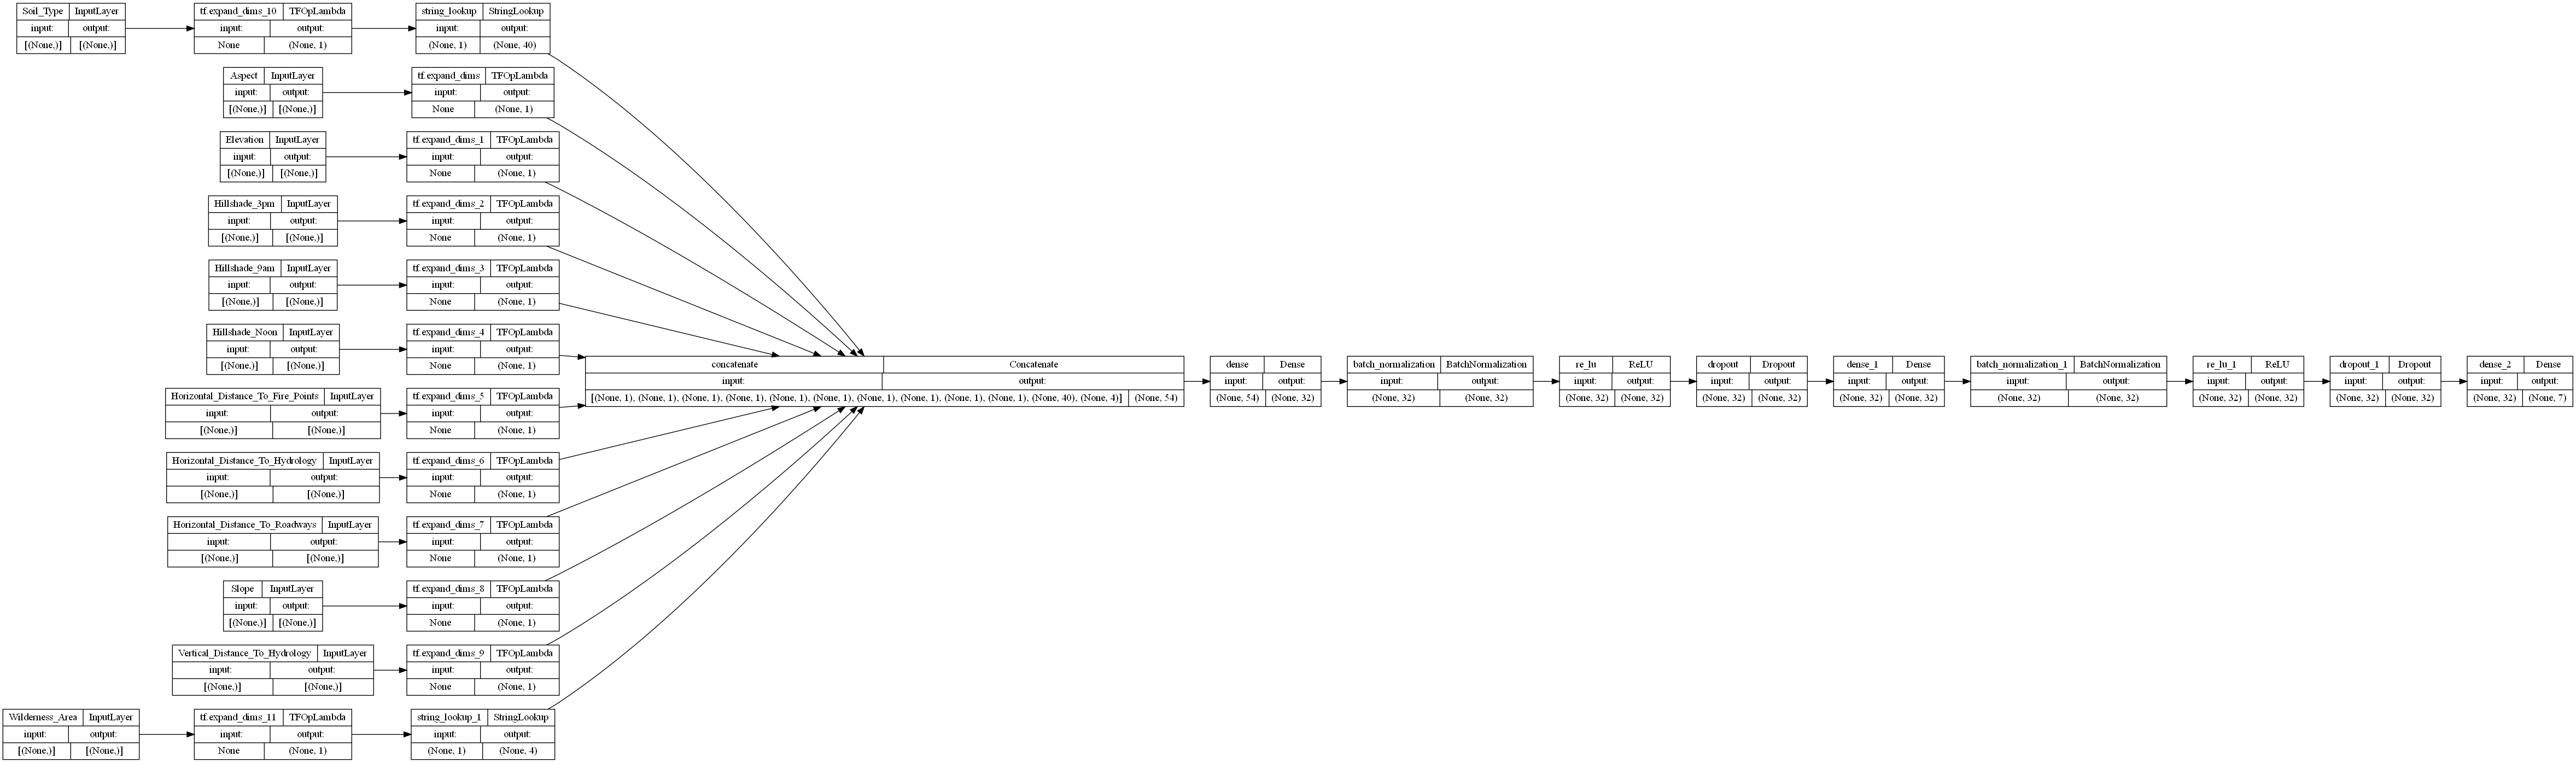

In [26]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [28]:
#Let's run it:

run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 18s 9ms/step - loss: 0.7811 - sparse_categorical_accuracy: 0.6780
Epoch 2/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6655 - sparse_categorical_accuracy: 0.7140
Epoch 3/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7253
Epoch 4/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.6188 - sparse_categorical_accuracy: 0.7334
Epoch 5/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.6061 - sparse_categorical_accuracy: 0.7393
Epoch 6/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5976 - sparse_categorical_accuracy: 0.7431
Epoch 7/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5910 - sparse_categorical_accuracy: 0.7468
Epoch 8/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5860 - sparse_categorical_accuracy: 0.7

In [29]:
""" The baseline linear model achieves ~73% test accuracy. """

' The baseline linear model achieves ~73% test accuracy. '

In [30]:
#Experiment 2: Wide & Deep model

"""
In the second experiment, we create a Wide & Deep model. The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the dense representation of the input features for the deep part of the model.

Note that every input features contributes to both parts of the model with different representations """

'\nIn the second experiment, we create a Wide & Deep model. The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.\n\nUse the sparse representation of the input features in the wide part of the model and the dense representation of the input features for the deep part of the model.\n\nNote that every input features contributes to both parts of the model with different representations '

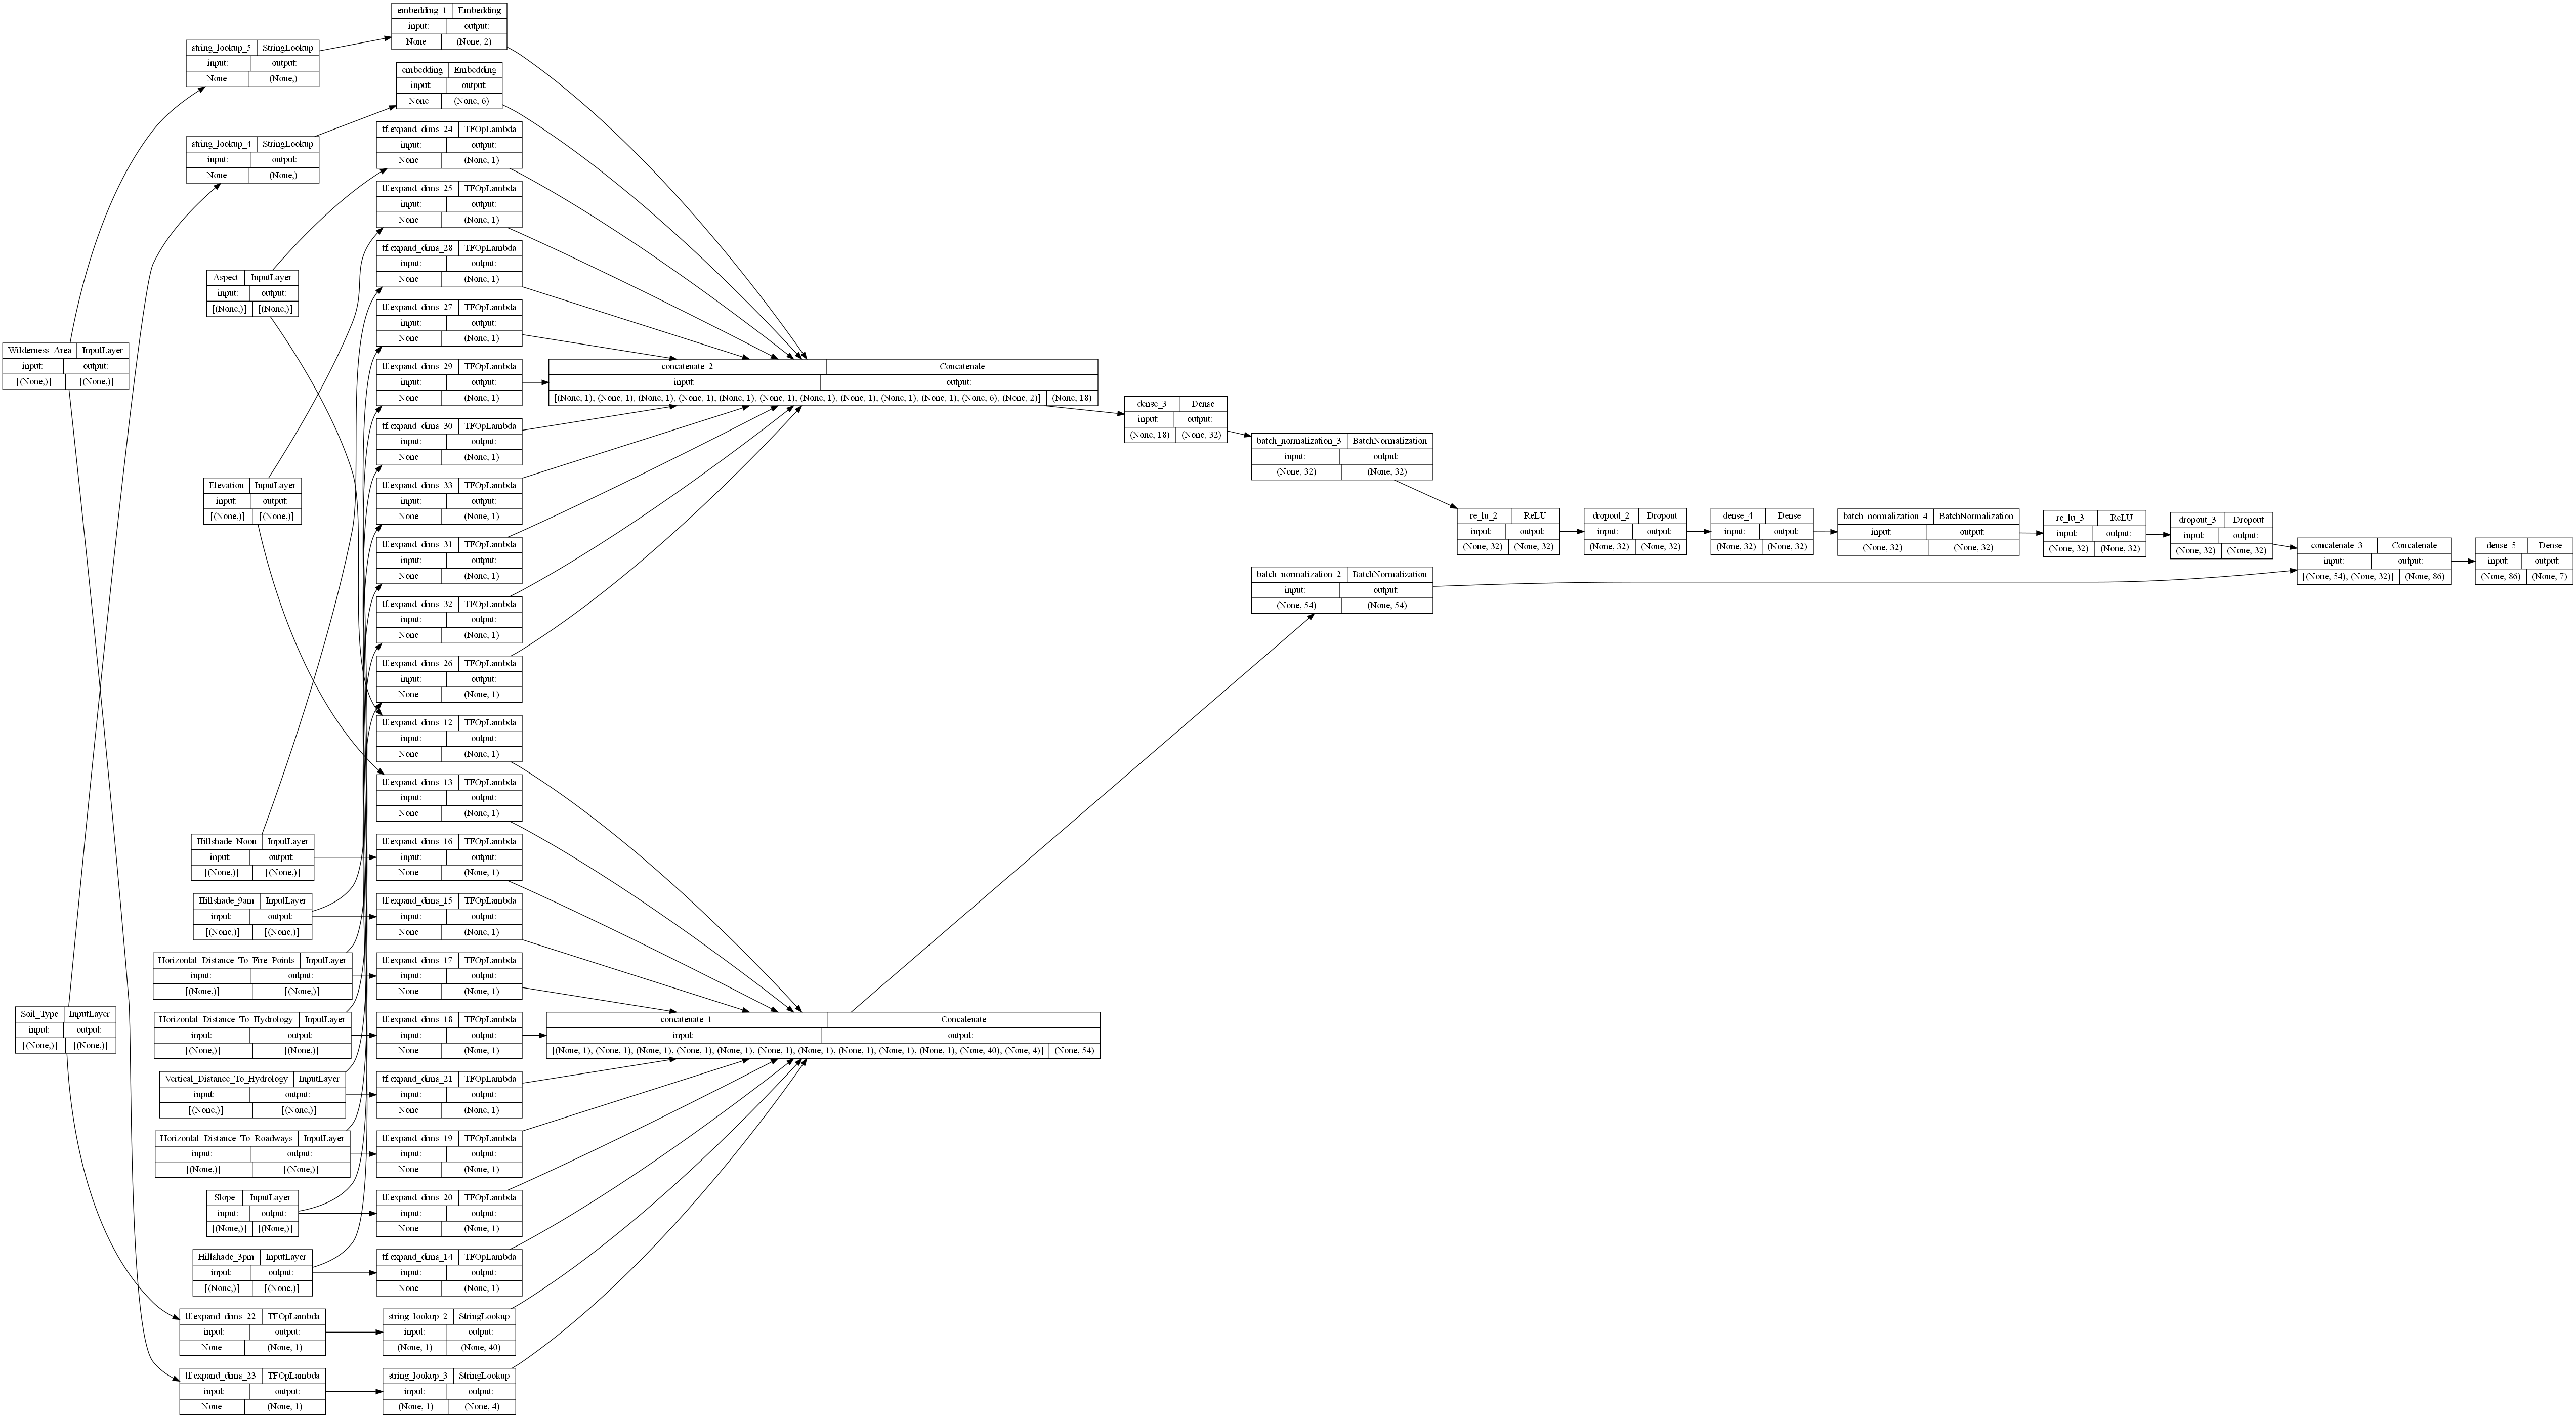

In [31]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [32]:
#Let's run it:

run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 18s 8ms/step - loss: 0.7193 - sparse_categorical_accuracy: 0.7031
Epoch 2/50
1864/1864 [==============================] - 14s 8ms/step - loss: 0.6070 - sparse_categorical_accuracy: 0.7369
Epoch 3/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5910 - sparse_categorical_accuracy: 0.7438
Epoch 4/50
1864/1864 [==============================] - 13s 7ms/step - loss: 0.5793 - sparse_categorical_accuracy: 0.7492
Epoch 5/50
1864/1864 [==============================] - 17s 9ms/step - loss: 0.5700 - sparse_categorical_accuracy: 0.7534
Epoch 6/50
1864/1864 [==============================] - 15s 8ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.7575
Epoch 7/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5560 - sparse_categorical_accuracy: 0.7601
Epoch 8/50
1864/1864 [==============================] - 18s 10ms/step - loss: 0.5511 - sparse_categorical_accuracy: 0.

In [33]:
""" The wide and deep model achieves ~79% test accuracy. """

' The wide and deep model achieves ~79% test accuracy. '

In [34]:
#Experiment 3: Deep & Cross model

"""In the third experiment, we create a Deep & Cross model. The deep part of this model is the same as the deep part created in the previous experiment. The key idea of the cross part is to apply explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth. """ 

'In the third experiment, we create a Deep & Cross model. The deep part of this model is the same as the deep part created in the previous experiment. The key idea of the cross part is to apply explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth. '

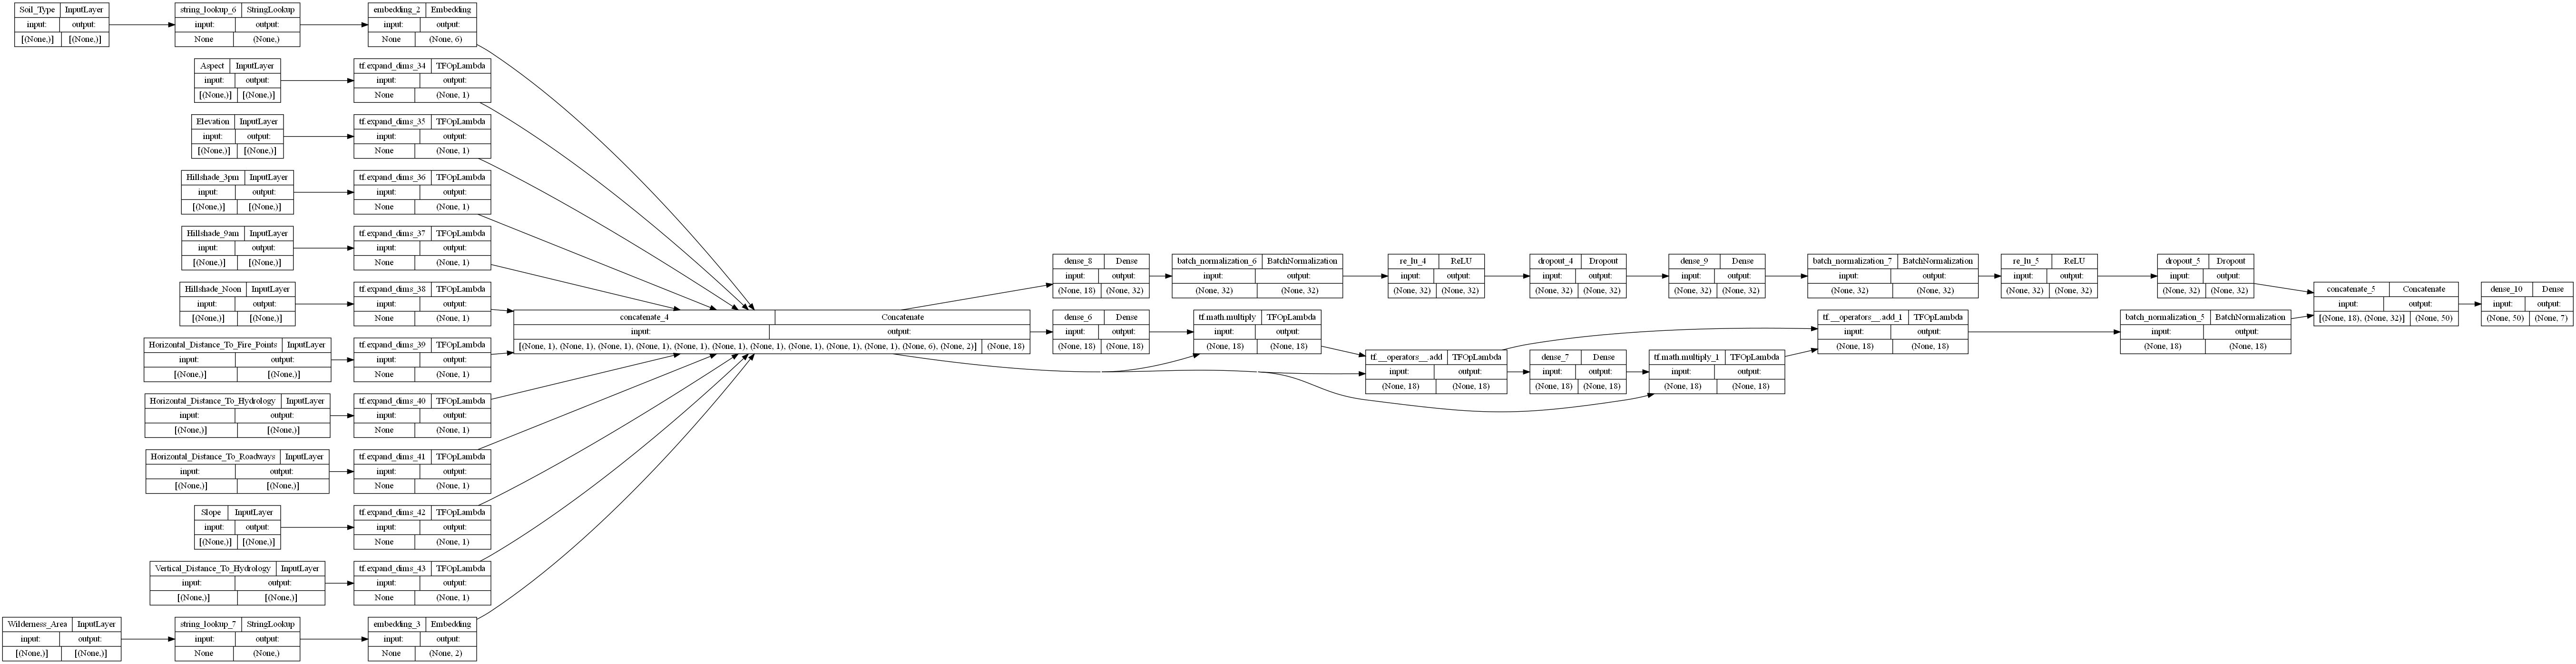

In [35]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [36]:
#Let's run it:

run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 17s 8ms/step - loss: 0.7031 - sparse_categorical_accuracy: 0.7071
Epoch 2/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5926 - sparse_categorical_accuracy: 0.7433
Epoch 3/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5719 - sparse_categorical_accuracy: 0.7515
Epoch 4/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5596 - sparse_categorical_accuracy: 0.7568
Epoch 5/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5507 - sparse_categorical_accuracy: 0.7610
Epoch 6/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5439 - sparse_categorical_accuracy: 0.7638
Epoch 7/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5383 - sparse_categorical_accuracy: 0.7667
Epoch 8/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5340 - sparse_categorical_accuracy: 0.7

In [37]:
""" The deep and cross model achieves ~81% test accuracy. """

' The deep and cross model achieves ~81% test accuracy. '

In [38]:
# Conclusion

""" Keras Preprocessing Layers can be used to easily process categorical features with various encoding mechanisms such as one-hot encoding and feature embedding. Moreover, different model architectures (wide, deep, cross networks, etc.) have different advantages with respect to different data set properties. You can use these individually or in combination to get the best results for your data set. """

' Keras Preprocessing Layers can be used to easily process categorical features with various encoding mechanisms such as one-hot encoding and feature embedding. Moreover, different model architectures (wide, deep, cross networks, etc.) have different advantages with respect to different data set properties. You can use these individually or in combination to get the best results for your data set. '